Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [38]:
from random import choices, random, shuffle
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 120
plt.rcParams.update({"font.size": 15})

import lab9_lib

# EA class

In [39]:
from dataclasses import dataclass

LOCI = 1000


@dataclass
class Individual:
    """Class for representing the single individual of the given problem."""

    genotype = choices([0, 1], k=LOCI)  # Genotype made of 0 and 1 randomly.
    fitness = float("-inf")  # Starting fitness value.

In [40]:
@dataclass
class Ea:
    """
    Class used for the implementation of an evolution algorithm strategy.

    Public-Methods: The class itself can be used as a function (__call__ method below)

    Keyword argument:
    bit_assign_strategy -- a boolean for choosing which mutation strategy will be adopted in the solution
    population_size -- size of the population in the evolution algorithm (default 200)
    offspring_size -- size of the offspring generated in each generation (default 200)
    mutation_prob -- probability to mutate a parent (default 0.2)
    tournament_size -- size of the tournament for selecting a parent (default 3)
    """

    bit_assign_strategy: bool = False
    population_size: int = 200
    offspring_size: int = 200
    mutation_prob: float = 0.2
    tournament_size: float = 3
    __prob_to_set_1 = 0.5  # probability to change a bit into 1
    __bit_change = 0.15  # probability to change a bit
    # used to track performances of __bit_setting_mutation
    # position 0 is for the performance of value 0, position 1 for value 1.
    __better_with_0_1 = [0, 0]
    __fitness = None  # fitness function for the problem to solve.

    def __create_population(self, custom_pop_size: int = 0) -> list[Individual]:
        """
        Function that creates the population.
        By default we use the population size of the class, but a custom_pop_size can be used.
        """
        r = custom_pop_size if custom_pop_size else self.population_size
        population = [Individual() for _ in range(r)]
        for p in population:
            p.fitness = self.__fitness(p.genotype)
        return population

    def __parent_selection(self, population: list[Individual]) -> Individual:
        """Given the population, a parent is selected using a tournament size approach"""
        # we randomly select tournament_size parent
        parents_idx = np.random.choice(
            range(len(population)), size=self.tournament_size, replace=False
        )
        parents = [population[idx] for idx in parents_idx]
        # we return the best parent of the selected one, based on fitness value.
        return max(parents, key=lambda i: i.fitness)

    def __uniform_cut_xover(
        self, ind1: Individual, ind2: Individual
    ) -> Individual:
        """Given two parent, we apply uniform crossover to generate a new child."""
        assert len(ind1.genotype) == len(ind2.genotype)
        # probability to choose from one parent is weighted on their fitness.
        p1 = ind1.fitness / (ind1.fitness + ind2.fitness)
        mask = np.random.choice(
            [True, False], size=len(ind1.genotype), p=[p1, 1 - p1]
        )
        gene = np.where(mask, ind1.genotype, ind2.genotype)
        new_ind = Individual()
        new_ind.genotype = gene.tolist()
        return new_ind

    def __bit_setting_mutation(self, parent: Individual) -> Individual:
        """
        Given a parent, we apply this mutation with a certain probability.
        If the mutation is applied, we choose a value to assign (0,1) based on previous performances
        and assign this chosen value to a each bit, with a certain probability.
        """
        if random() < self.mutation_prob:
            new_offspring = deepcopy(parent)
            bit_val = 1 if random() < self.__prob_to_set_1 else 0
            for i in range(len(parent.genotype)):
                if random() < self.__bit_change:
                    new_offspring.genotype[i] = bit_val
            new_offspring.fitness = self.__fitness(new_offspring.genotype)
            if new_offspring.fitness > parent.fitness:
                self.__better_with_0_1[bit_val] += 1
            return new_offspring
        else:
            # no mutation, just fitness calculation
            parent.fitness = self.__fitness(parent.genotype)
            return parent

    def __bit_flip_mutation(self, parent: Individual) -> Individual:
        """
        Given a parent, we apply this mutation with a certain probability.
        If the mutation is applied, we flip each bit with a certain probability.
        """
        if random() < self.mutation_prob:
            new_offspring = deepcopy(parent)
            for i in range(len(parent.genotype)):
                if random() < self.__bit_change:
                    new_offspring.genotype[i] = int(
                        not new_offspring.genotype[i]
                    )
            new_offspring.fitness = self.__fitness(new_offspring.genotype)
            return new_offspring
        else:
            # no mutation, just fitness calculation
            parent.fitness = self.__fitness(parent.genotype)
            return parent

    def __self_adapt_mutation(self):
        """
        This function adapts the probability to choose a certain value for the
        bit_assign_strategy based on the performance over a whole generation
        """
        if self.__better_with_0_1[1] > self.__better_with_0_1[0]:
            self.__prob_to_set_1 += 0.1
        else:
            self.__prob_to_set_1 -= 0.1
        # resetting the performance tracker.
        self.__better_with_0_1 = [0, 0]

    def __create_generation(
        self, population: list[Individual]
    ) -> list[Individual]:
        """Given a population, we create a new generation"""
        offsprings = []
        for _ in range(self.offspring_size):
            parent1 = self.__parent_selection(population)
            parent2 = self.__parent_selection(population)
            offspring = self.__uniform_cut_xover(parent1, parent2)
            offspring = (
                self.__bit_flip_mutation(offspring)
                if self.bit_assign_strategy
                else self.__bit_setting_mutation(offspring)
            )
            offsprings.append(offspring)
        if not self.__bit_flip_mutation:
            # after a generation we adapt the probability of the __bit_assign_mutation if chosen.
            self.__self_adapt_mutation()
        return offsprings

    def __survival_selection(
        self, population: list[Individual], offsprings: list[Individual]
    ) -> list[Individual]:
        """Given the population and the offspring, we unite them and choose the pop_size best one."""
        population.extend(offsprings)
        population.sort(key=lambda i: i.fitness, reverse=True)
        # keep the first population_size best individuals
        population = population[: self.population_size]
        return population

    def __island_model(
        self,
        n_island: int,
        fitness_stall_limit: int,
        migration_frequency: int,
        migration_number: int,
    ) -> (float, list[int], list[float]):
        """Create an evolution algorithm implementation using the island model ."""
        # islands creation
        islands = [
            self.__create_population(self.population_size // n_island)
            for _ in range(n_island)
        ]
        gen = 0
        fitness_stall = 0
        best_fitness = float("-inf")
        # this lists below are used for the plots.
        fitness_list = []
        gen_list = []
        while fitness_stall < fitness_stall_limit:
            old_best = best_fitness
            # evolve each island for a given number of generations.
            for _ in range(migration_frequency):
                for index, island in enumerate(islands):
                    offsprings = self.__create_generation(island)
                    new_island = self.__survival_selection(island, offsprings)
                    best_fitness = (
                        new_island[0].fitness
                        if new_island[0].fitness > best_fitness
                        else best_fitness
                    )
                    islands[index] = new_island
                gen += 1
                fitness_list.append(best_fitness)
                gen_list.append(gen)

            # choose the migrants for each island randomly.
            migrants = []
            for index, island in enumerate(islands):
                m = np.random.choice(
                    island, size=migration_number, replace=False
                )
                # remove migrants from the corresponding island
                islands[index] = [ind for ind in island if ind not in m]
                migrants.append(m)

            # shuffle the migrants array and then put the migrants into the corresponding island.
            shuffle(migrants)
            for index, island in enumerate(islands):
                island.extend(migrants[index])

            fitness_stall = fitness_stall + 1 if best_fitness == old_best else 0
        return best_fitness, gen_list, fitness_list

    def __classic_ea(
        self, fitness_stall_limit: int
    ) -> (float, list[int], list[float]):
        """A classic evolution algorithm implemetation."""
        population = self.__create_population()
        best_fitness = float("-inf")
        gen = 0
        fitness_stall = 0
        fitness_list = []
        gen_list = []
        while fitness_stall < fitness_stall_limit:
            offsprings = self.__create_generation(population)
            population = self.__survival_selection(population, offsprings)

            # if stalling increment the fitness stall variable, else reset it.
            fitness_stall = (
                fitness_stall + 1
                if best_fitness == population[0].fitness
                else 0
            )

            # fitness_list.append(best_fitness)
            gen += 1
            fitness_list.append(best_fitness)
            gen_list.append(gen)

        return population[0].fitness, gen_list, fitness_list

    def __call__(
        self,
        fitness: callable,
        island_solution: bool = False,
        n_island: int = 4,
        migration_frequency: int = 20,
        migration_number: int = 20,
    ) -> (float, list[int], list[float]):
        """Use the right evolution algorithm implementation."""
        self.__fitness = fitness
        if island_solution:
            fitness_stall_limit = 60 / migration_frequency
            return self.__island_model(
                n_island,
                fitness_stall_limit,
                migration_frequency,
                migration_number,
            )
        else:
            fitness_stall_limit = 100
            return self.__classic_ea(fitness_stall_limit)

# Results

In [41]:
def plot(history_dict: dict, model="") -> None:
    colors = {1: "red", 2: "blue", 5: "green", 10: "orange"}
    plt.title(f"{model}")
    plt.xlabel("#generation")
    plt.ylabel("fitness")
    for k, v in history_dict.items():
        plt.plot(v[1], label=f"k = {k}", color=colors[k])
        plt.axvline(x=v[0][-1], color=colors[k], linestyle="dashed")
    plt.legend()
    plt.show()

In [42]:
def run_ea(ea: Ea, title: str, island_solution: bool, n_island: int = 4):
    history_dict = {}
    instance = [1, 2, 5, 10]
    for k in instance:
        fitness = lab9_lib.make_problem(k)
        best_individual, gen_list, fitness_list = ea(
            fitness, island_solution=island_solution, n_island=n_island
        )
        history_dict[k] = (gen_list, fitness_list)
        best_fitness = best_individual
        print(
            f"Problem instance: {k}, Best individual fitness: {best_fitness}, Generation num: {gen_list[-1]}, Fitness calls: {fitness.calls} -> fitness/fitness_call adjusted: {best_fitness/fitness.calls*10000000:.4f}"
        )

    # PLOT
    plot(history_dict, model=title)

### Bit flip mutation, no island model

Problem instance: 1, Best individual fitness: 1.0, Generation num: 135, Fitness calls: 27200 -> fitness/fitness_call adjusted: 367.6471
Problem instance: 2, Best individual fitness: 1.0, Generation num: 299, Fitness calls: 60000 -> fitness/fitness_call adjusted: 166.6667
Problem instance: 5, Best individual fitness: 0.71, Generation num: 132, Fitness calls: 26600 -> fitness/fitness_call adjusted: 266.9173
Problem instance: 10, Best individual fitness: 0.48677931, Generation num: 762, Fitness calls: 152600 -> fitness/fitness_call adjusted: 31.8990


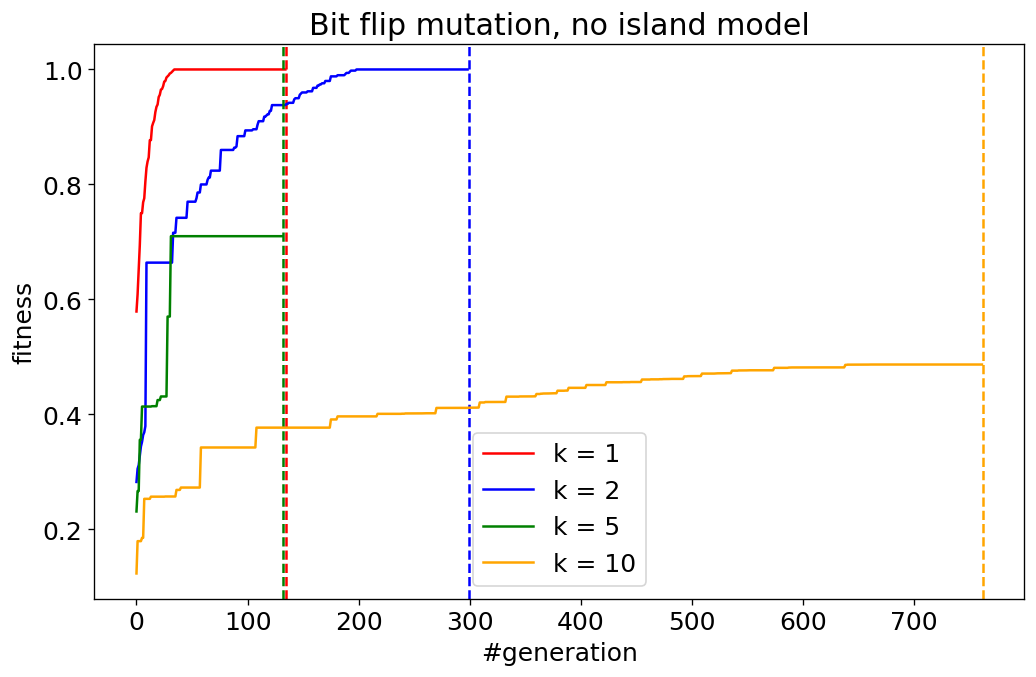

In [56]:
ea = Ea(
    bit_assign_strategy=False,
    population_size=200,
    offspring_size=200,
    mutation_prob=0.2,
    tournament_size=3,
)

run_ea(ea, title="Bit flip mutation, no island model", island_solution=False)

### Bit flip mutation, with island model

Problem instance: 1, Best individual fitness: 1.0, Generation num: 100, Fitness calls: 80200 -> fitness/fitness_call adjusted: 124.6883
Problem instance: 2, Best individual fitness: 1.0, Generation num: 240, Fitness calls: 192200 -> fitness/fitness_call adjusted: 52.0291
Problem instance: 5, Best individual fitness: 0.5748, Generation num: 80, Fitness calls: 64200 -> fitness/fitness_call adjusted: 89.5327
Problem instance: 10, Best individual fitness: 0.4123598, Generation num: 160, Fitness calls: 128200 -> fitness/fitness_call adjusted: 32.1654


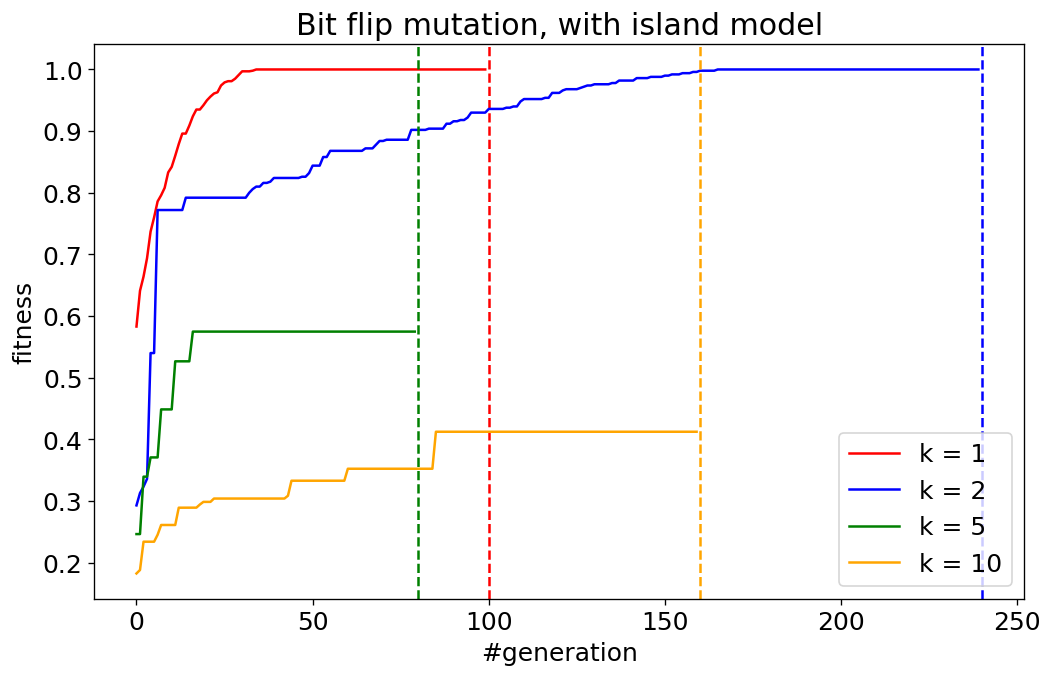

In [44]:
ea = Ea(
    bit_assign_strategy=False,
    population_size=200,
    offspring_size=200,
    mutation_prob=0.2,
    tournament_size=3,
)

run_ea(
    ea,
    title="Bit flip mutation, with island model",
    island_solution=True,
    n_island=4,
)

### Bit assign strategy, no island model

Problem instance: 1, Best individual fitness: 0.952, Generation num: 213, Fitness calls: 43000 -> fitness/fitness_call adjusted: 221.3953
Problem instance: 2, Best individual fitness: 0.856, Generation num: 1052, Fitness calls: 210800 -> fitness/fitness_call adjusted: 40.6072
Problem instance: 5, Best individual fitness: 0.525, Generation num: 336, Fitness calls: 67600 -> fitness/fitness_call adjusted: 77.6627
Problem instance: 10, Best individual fitness: 0.26969239, Generation num: 239, Fitness calls: 48200 -> fitness/fitness_call adjusted: 55.9528


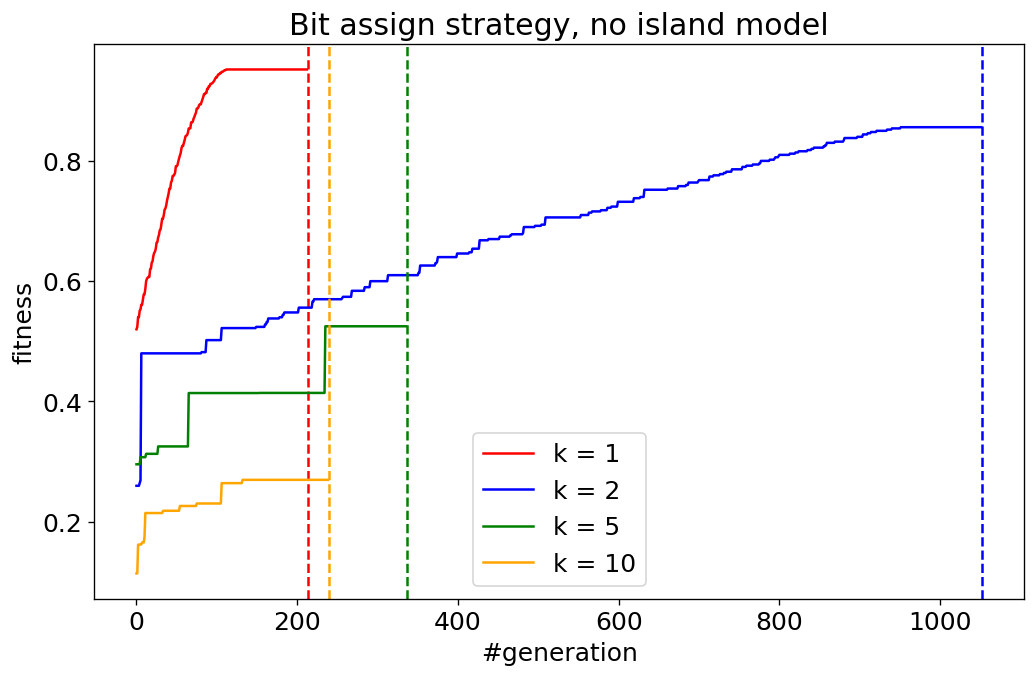

In [66]:
ea = Ea(
    bit_assign_strategy=True,
    population_size=400,
    offspring_size=200,
    mutation_prob=0.2,
    tournament_size=3,
)

run_ea(ea, title="Bit assign strategy, no island model", island_solution=False)

### Bit assign strategy, with island model

Problem instance: 1, Best individual fitness: 0.912, Generation num: 180, Fitness calls: 144400 -> fitness/fitness_call adjusted: 63.1579
Problem instance: 2, Best individual fitness: 0.486, Generation num: 80, Fitness calls: 64400 -> fitness/fitness_call adjusted: 75.4658
Problem instance: 5, Best individual fitness: 0.4305, Generation num: 140, Fitness calls: 112400 -> fitness/fitness_call adjusted: 38.3007
Problem instance: 10, Best individual fitness: 0.3006733, Generation num: 120, Fitness calls: 96400 -> fitness/fitness_call adjusted: 31.1902


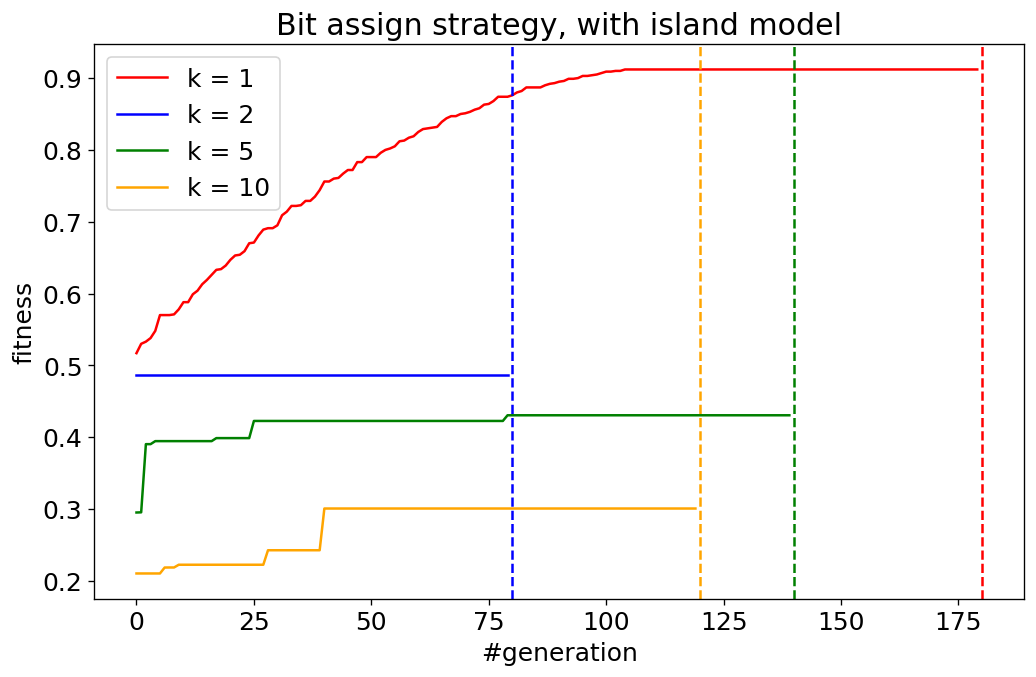

In [85]:
ea = Ea(
    bit_assign_strategy=True,
    population_size=400,
    offspring_size=200,
    mutation_prob=0.2,
    tournament_size=3,
)

run_ea(
    ea,
    title="Bit assign strategy, with island model",
    island_solution=True,
    n_island=4,
)